# CPC Librispeech Reproduction

Notebook for reproducing the CPC paper Librispeech results.

## Imports

In [32]:
!TMPDIR=../../tmp pip install torchaudio==0.5.* torch==1.5.* torchsummary==1.5.1 numpy pandas matplotlib

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=8b9a3f59f39b51263c42e5253a44f026218cb6625872b7f4084cd0796f4ec9d7
  Stored in directory: /home/mi/rbergmann/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
from torchaudio.datasets import LIBRISPEECH
from torchaudio.datasets.utils import extract_archive
from torch.utils.data import DataLoader, random_split
from torchaudio.transforms import Spectrogram

from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from timeit import default_timer as timer

#from google.colab import drive

## Config

In [17]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
RND_SEED = 1
NUM_SPEAKERS = 251
BATCH_SIZE = 64
AUDIO_WINDOW = 20480
N_STEPS = 12

torch.random.manual_seed(RND_SEED)
torch.cuda.manual_seed(RND_SEED)

DEVICE

device(type='cuda')

# Data



## Phonemes

> Although the dataset does not provide labels other than the raw text, we obtained force-aligned phone sequences with the Kaldi toolkit [31] and pre-trained models on Librispeech1. We have made the aligned phonelabels and our train/test split available for download on Google Drive2. The dataset contains speech from 251 different speakers.

In [ ]:
#drive.mount('/content/drive')

In [ ]:
#train_split_labels = pd.read_csv('/content/drive/My Drive/ma/train_split.txt')
#test_split_labels = pd.read_csv('/content/drive/My Drive/ma/test_split.txt')
#converted_aligned_phones = pd.read_csv('/content/drive/My Drive/ma/converted_aligned_phones.txt', sep=' ', header=None, usecols=range(0, 1097))

In [ ]:
#print(converted_aligned_phones.shape, train_split_labels.shape, test_split_labels.shape)
#train_split_labels # 80/20 split
#converted_aligned_phones

Extract the archive.

In [ ]:
#!wget www.openslr.org/resources/12/train-clean-100.tar.gz
#!mv train-clean-100.tar.gz '/content/drive/My Drive/'
#!tar xzf 'drive/My Drive/ma/train-clean-100.tar.gz' -C ./

Pytorch has a dataset ...

In [ ]:
# copy to runtime local storage to speed things up manifold
#!rsync -P --append-verify -r drive/My\ Drive/LibriSpeech ./
#!rm -r ./LibriSpeech

## Speaker ID

In [3]:
libri_data = LIBRISPEECH('./', url='train-clean-100', download=False)

100.0%


In [4]:
len(libri_data), round(len(libri_data) * .8), len(libri_data) - round(len(libri_data) * .8)

(28539, 22831, 5708)

We could probably use a custom sampler to get the exact split via the provided labels but let's skip this for now.

In [18]:
train_data, test_data = random_split(libri_data, [22831, 5708])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

(len(train_loader), len(test_loader))

(356, 89)

> Each item is a tuple of the form: waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id

In [19]:
train_loader.dataset[0]

(tensor([[ 0.0069,  0.0042, -0.0016,  ...,  0.0006,  0.0019,  0.0020]]),
 16000,
 'IN THE DIRECTION OF THE ENEMY EARLY IN THE FIGHT I CAME UPON CHURCH ATTENDING TO A YOUNG COWBOY WHO WAS SHOT THROUGH THE CHEST',
 5049,
 25947,
 107)

We need to map the labels to [0 - NUM_SPEAKERS]. Instead of looping over everything we will just list the folders for their name is the speaker ID. We then keep a forward and a backward mapping.

In [20]:
#label_mapping_to_dataset = dict(enumerate(np.unique([int(k) for k in os.listdir('drive/My Drive/LibriSpeech/train-clean-100')])))
label_mapping_to_dataset = dict(enumerate(np.unique([int(k) for k in os.listdir('./LibriSpeech/train-clean-100')])))
label_mapping_from_dataset = {v: k for k, v in label_mapping_to_dataset.items()}
assert(len(label_mapping_to_dataset) == NUM_SPEAKERS)

label_mapping_from_dataset[train_loader.dataset[0][3]]

159

In [21]:
(train_loader.dataset[0][0].shape, train_loader.dataset[1][0].shape, train_loader.dataset[2][0].shape)

(torch.Size([1, 165680]), torch.Size([1, 239520]), torch.Size([1, 241280]))

All different lengths - we can't use this with DataLoader. But we need to subsample a 20480 sequence anyway.

### Sequence Sampling

In [22]:
def subsample(batch):
    '''
    Sample a 20480-width sequence from each sequence.
    '''
    # let's just keep wav and speaker ID
    x, _, _, y, _, _ = zip(*batch)
    # translate to class-labels and make it a tensor
    y = [torch.tensor(label_mapping_from_dataset[label]) for label in y]
    # assuming all seqs are > 20480
    #print([seq.shape[1] for seq in x]) # seq.shape is (1,seq_len)
    x = [torch.squeeze(v) for v in x]
    # we sample a sequence of length 20480, so we need an index between 0 and seq_len - 20480
    indexes = [np.random.randint(len(seq) - AUDIO_WINDOW) for seq in x] # TODO: +1 or not?
    #print(indexes)
    x = [torch.narrow(x[i], 0, indexes[i], AUDIO_WINDOW) for i in range(len(batch))]
    # stack batch
    x = torch.stack(x, 0)
    y = torch.stack(y, 0)
    return x, y

### Loaders

In [23]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, 
                          collate_fn=subsample, drop_last=True
                         )
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, 
                         collate_fn=subsample, drop_last=True
                         )

In [ ]:
for i, v in enumerate(train_loader):
    print(v[0].shape, v[1].shape, v[1])
    for b in range(v[0].shape[0]):
        print(v[0][b].shape)
    if i > 0: break

## Visalization

Let's get a view of a sample. Just for our mental model.

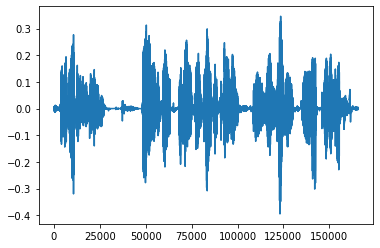

In [25]:
plt.figure()
plt.plot(train_loader.dataset[0][0].t().numpy())

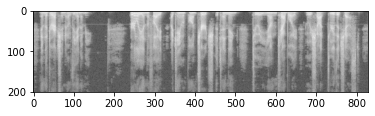

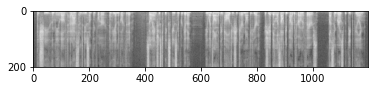

In [26]:
specgram = Spectrogram()(train_loader.dataset[0][0])
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

specgram = Spectrogram()(train_loader.dataset[1][0])
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

# CPC

## Model

> The encoder architecture $g_{enc}$ used in our experiments consists of a strided convolutional neural network that runs directly on the 16KHz PCM audio waveform. We use five convolutional layers with strides [5, 4, 2, 2, 2], filter-sizes [10, 8, 4, 4, 4] and 512 hidden units with ReLU activations. The total downsampling factor of the network is 160 so that there is a feature vector for every 10ms ofspeech, which is also the rate of the phoneme sequence labels obtained with Kaldi. We then use a GRU RNN [17] for the autoregressive part of the model, $g_{ar}$ with 256 dimensional hidden state. The output of the GRU at every timestep is used as the context $c$ from which we predict 12 timesteps in the future using the contrastive loss.



In [27]:
class CPC(nn.Module):
    def __init__(self, n_steps, n_speaker):
        super(CPC, self).__init__()
        self.n_steps = n_steps
        self.n_speaker = n_speaker
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(256, 512) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        # for a batch of 8 we need 8x8 targets with ones on the diagonal
        # it's always the same target, we can reuse it
        #self.cpc_target = torch.diag(torch.ones(BATCH_SIZE)).to(DEVICE)
        self.cpc_target = torch.arange(0, BATCH_SIZE).long().to(DEVICE) # for CE/NLL

    def encoder(self):
        return nn.Sequential(
            # TODO: add batch norms?
            # padding not mentioned but w\o we get 126 instead of 128
            nn.Conv1d(1, 512, 10, 5, 3),
            nn.ReLU(),
            nn.Conv1d(512, 512, 8, 4, 2),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
        )
        
    def autoregressive(self):
        return nn.GRU(512, 256, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            z = self.g_enc(x)
            z = z.permute(0, 2, 1)
            pred, hidden = self.g_ar(z, hidden)
            return pred[:,-1,:], hidden

    def forward(self, x, gar_hidden):
        # put through g_enc
        z = self.g_enc(x)
        #print(z.shape) # 8,512,128

        # sample a subsequence of n steps, 1/160 is the downsampling from the encoder
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,)) # 1-116
        # we can't pick a different index for each sample of the batch or we cannot process them as a batch
        # for the pieces would have different lengths --- or we would have to pad them to the same length again
        # our data loader shuffles so this should not be too much of a bummer
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        z = z.permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden)
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        # W_k * c_t
        pred = [self.step_W[step](c_t) for step in range(N_STEPS)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []
        for time_step in range(N_STEPS):
            # f_k = exp(z_{t+k} * W_k * c_t)
            f_k = torch.mm(z[:,subsample_idx + time_step,:].squeeze(), torch.transpose(pred[time_step], 0, 1))
            info_nce_loss.append(self.loss_criterion(f_k, self.cpc_target))
            accuracy = torch.mean((torch.argmax(f_k, dim=1) == self.cpc_target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()
        
        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, BATCH_SIZE, 256).to(DEVICE)

## Train CPC

> We train on sampled audio windows of length 20480. We usethe Adam optimizer [32] with a learning rate of $2^{-4}$, and use 8 GPUs each with a minibatch of 8 examples from which the negative samples in the contrastive loss are drawn. The model is trained until convergence, which happens roughly at 300,000 updates.

In [28]:
def train(model, epoch, optimizer, data_loader):
    model.train()
    loss = 0 # epoch loss
    acc = 0  # epoch acc
    epoch_loss = []
    epoch_acc = []
    for batch_idx, (x, y) in enumerate(data_loader):
        time_batch_start = timer()
        optimizer.zero_grad()
        
        # add channel dimension
        if len(x.shape) < 3:
            x = x.unsqueeze(1).to(DEVICE)
        
        # fwd - info_nce loss inside forward
        loss, accuracy = model(x, model.empty_hidden())
        
        # back
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy)

        # progress report every couple updates
        if batch_idx % 40 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}\tAcc: {:.2f}%\tTime: {:.6f}'.format(
                    epoch,
                    batch_idx * BATCH_SIZE,
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader),
                    loss,
                    accuracy * 100,
                    timer() - time_batch_start
                ))
            
    return torch.mean(torch.tensor(epoch_loss, dtype=torch.float64)), torch.mean(torch.tensor(epoch_acc, dtype=torch.float64))

In [35]:
# CPC model with vertical slice for negatives (fast)
model = CPC(N_STEPS, NUM_SPEAKERS).to(DEVICE)
# CPC model with full negative sampling (loop, slow)
#model = CPC_full_neg(N_STEPS, NUM_SPEAKERS).to(DEVICE)
# CPC model with full negative sampling (vectorized)
#model = CPC_full_neg_v(N_STEPS, NUM_SPEAKERS).to(DEVICE)
#model = CPC_full_neg_v2(N_STEPS, NUM_SPEAKERS).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
#model

In [36]:
summary(model.g_enc, (1, 20480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 512, 4096]           5,632
              ReLU-2            [-1, 512, 4096]               0
            Conv1d-3            [-1, 512, 1024]       2,097,664
              ReLU-4            [-1, 512, 1024]               0
            Conv1d-5             [-1, 512, 512]       1,049,088
              ReLU-6             [-1, 512, 512]               0
            Conv1d-7             [-1, 512, 256]       1,049,088
              ReLU-8             [-1, 512, 256]               0
            Conv1d-9             [-1, 512, 128]       1,049,088
             ReLU-10             [-1, 512, 128]               0
Total params: 5,250,560
Trainable params: 5,250,560
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 47.00
Params size (MB): 20.03
Estim

In [37]:
loss_cpc = []
acc_cpc = []

## Run

In [ ]:
for epoch in range(20):
    l, a = train(model, epoch, optimizer, train_loader)
    loss_cpc.append(l)
    acc_cpc.append(a)

### Training Loss

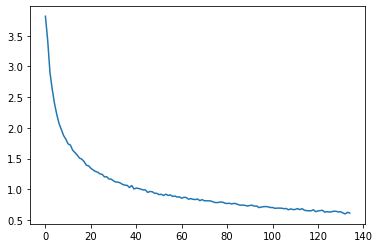

In [112]:
plt.figure()
plt.plot(np.arange(len(loss_cpc)), loss_cpc)

### Training Accuracy

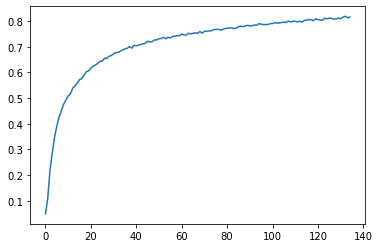

In [113]:
plt.figure()
plt.plot(np.arange(len(acc_cpc)), acc_cpc)

We could test the CPC objective against the validation set in the same way. Pick a random index, feed the $g_{ar}$ to this index, make predictions and see how well the $W_k$ perform.

# Classifier

This is the speaker classifier - a simple linear one.

> [...] with a linear classifier from the same representation [...]

In [41]:
class SpeakerClassifier(nn.Module):
    '''Classifier for speaker identification - simple linear.'''
    def __init__(self, n_speaker):
        super(SpeakerClassifier, self).__init__()
        self.n_speaker = n_speaker
        self.classifier = nn.Sequential(
            nn.Linear(256, n_speaker)
        )

    def forward(self, x):
        return self.classifier(x)

## Train Classifier

In [42]:
def train_speaker_clfy(cpc_model, classifier, optimizer, loss_fn, epoch, data_loader):
    cpc_model.to(DEVICE)
    cpc_model.eval()
    classifier.train()

    epoch_loss = []
    epoch_acc = []
    
    for batch_idx, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()

        # add channel dim
        x = x.unsqueeze(1).to(DEVICE)
        y.to(DEVICE)
        #print(x.shape) # 8,1,20480

        # cpc output
        output, hidden = cpc_model.predict(x)
        c_t = output.contiguous().view((-1,256))

        #print(output.shape, c_t.shape) # 8,256
        
        # shuffle batch
        y = y.view((-1,1)) # to column
        shuffle_idx = torch.randperm(BATCH_SIZE) 
        c_t = c_t[shuffle_idx,:]
        y = y[shuffle_idx,:].view((-1,)) # to row
        
        # classifier fwd
        c_t = c_t.to(DEVICE)
        y = y.to(DEVICE)
        output = classifier(c_t)

        #print(output.shape, output.max(1, keepdim=True)[1])

        # loss & backprop
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        # metrics
        pred = output.max(1, keepdim=True)[1]
        acc = 1. * pred.eq(y.view_as(pred)).sum().item() / BATCH_SIZE

        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        
        if batch_idx % 160 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.2f}\tLoss: {:.6f}'.format(
                epoch, batch_idx * BATCH_SIZE, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), acc, loss.item()))
        
    return torch.mean(torch.tensor(epoch_loss)), torch.mean(torch.tensor(epoch_acc))

In [125]:
classifier = SpeakerClassifier(NUM_SPEAKERS).to(DEVICE)
optimizer_clfy = torch.optim.Adam(classifier.parameters())
loss_clfy = nn.CrossEntropyLoss()

In [126]:
loss_hist_clfy = []
acc_hist_clfy = []

In [ ]:
for epoch in range(20):
    l, a = train_speaker_clfy(model, classifier, optimizer_clfy, loss_clfy, epoch, train_loader)
    loss_hist_clfy.append(l)
    acc_hist_clfy.append(a)

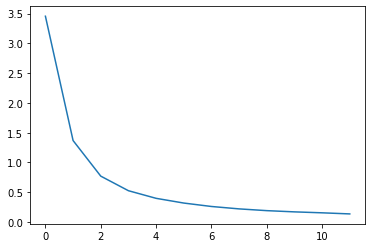

In [128]:
plt.figure()
plt.plot(np.arange(len(loss_hist_clfy)), loss_hist_clfy)

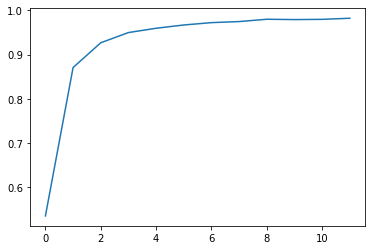

In [129]:
plt.figure()
plt.plot(np.arange(len(acc_hist_clfy)), acc_hist_clfy)

# Validation

In [68]:
def validate(cpc_model, classifier, data_loader):
    cpc_model.eval()
    classifier.eval()
    total_loss = 0
    total_acc  = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.float().unsqueeze(1).to(DEVICE) # add channel dimension
            y = y.to(DEVICE)
            output, hidden = cpc_model.predict(x)
            x = output.contiguous().view((-1,256))
            y = y.view((-1,))
            output = classifier.forward(x)
            total_loss += loss_fn(output, y).item()
            pred = output.max(1, keepdim=True)[1]
            total_acc += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(data_loader.dataset)
    total_acc /= 1. * len(data_loader.dataset)

    print('Validation: loss: {:.4f}\tAccuracy: {:.4f}\n'.format(total_loss, total_acc))

In [130]:
validate(model, classifier, test_loader)

Validation: loss: 0.0021	Accuracy: 0.9783



# Loading & Saving

In [108]:
#import json
#drive.mount('/content/drive')

In [110]:
#CHECKPOINT_PATH = '/content/drive/My Drive/ma/cpc_checkpoint_fn.pt'
CHECKPOINT_PATH = './cpc_checkpoint.pt'

## Saving

save weights, optimizer & metrics

In [114]:
# in case there are some tensors map everything to plain numbers
acc_cpc = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, acc_cpc))
loss_cpc = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, loss_cpc))

model.cpu() # move to CPU for saving
cpc_checkpoint = {
    'params': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': loss_cpc,
    'acc': acc_cpc
}
torch.save(cpc_checkpoint, CHECKPOINT_PATH)

model.to(DEVICE) # move back to target device
print()

## Loading

In [ ]:
cpc_checkpoint = torch.load(CHECKPOINT_PATH)

#model = CPC(N_STEPS, NUM_SPEAKERS)
model.load_state_dict(cpc_checkpoint['params'])
model.to(DEVICE)

optimizer.load_state_dict(cpc_checkpoint['optimizer'])
loss_cpc = cpc_checkpoint['loss']
acc_cpc = cpc_checkpoint['acc']
print()

In [124]:
## loading for 98params
model = torch.load('cpc_98.params')
model.to(DEVICE)

CPC(
  (g_enc): Sequential(
    (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(512, 512, kernel_size=(8,), stride=(4,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): ReLU()
    (8): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (g_ar): GRU(512, 256, batch_first=True)
  (step_W): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): Linear(in_features=256, out_features=512,

# Playground

## Full negative sampling (loop)

Draws negative samples from whole $z$ but it's very slow.

In [45]:
class CPC_full_neg(nn.Module):
    def __init__(self, n_steps, n_speaker):
        super(CPC_full_neg, self).__init__()
        self.n_steps = n_steps
        self.n_speaker = n_speaker
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(256, 512) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        # for a batch of 8 we need 8x8 targets with ones on the diagonal
        # it's always the same target, we can reuse it
        #self.cpc_target = torch.diag(torch.ones(BATCH_SIZE)).to(DEVICE)
        #self.cpc_target = torch.arange(0, BATCH_SIZE).long().to(DEVICE) # for CE/NLL

    def encoder(self):
        return nn.Sequential(
            # TODO: add batch norms?
            # padding not mentioned but w\o we get 126 instead of 128
            nn.Conv1d(1, 512, 10, 5, 3),
            nn.ReLU(),
            nn.Conv1d(512, 512, 8, 4, 2),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
        )
        
    def autoregressive(self):
        return nn.GRU(512, 256, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            z = self.g_enc(x)
            z = z.permute(0, 2, 1)
            pred, hidden = self.g_ar(z, hidden)
            return pred[:,-1,:], hidden

    def forward(self, x, gar_hidden):
        # put through g_enc
        z = self.g_enc(x)
        #print(z.shape) # 8,512,128

        # sample a subsequence of n steps, 1/160 is the downsampling from the encoder
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,)) # 1-116
        # we can't pick a different index for each sample of the batch or we cannot process them as a batch
        # for the pieces would have different lengths --- or we would have to pad them to the same length again
        # our data loader shuffles so this should not be too much of a bummer
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        z = z.permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden)
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        pred = [self.step_W[step](c_t) for step in range(N_STEPS)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []

        for time_step in range(N_STEPS):
            # init target vector
            target = torch.zeros((BATCH_SIZE,)).long().to(DEVICE) # eq batch size, one correct index per sample
            manual_batch = torch.zeros((BATCH_SIZE, BATCH_SIZE)).to(DEVICE) # N samples, N candidates

            # let's do the sampling per sample in the batch
            for sample_idx in range(BATCH_SIZE):    
                # density of positive, f_k(x_t+k, c_t)
                f_k = torch.mm(z[sample_idx,subsample_idx + time_step,:], pred[time_step][sample_idx,:].unsqueeze(dim=1))
                # put positive at random index
                test_v = torch.zeros((BATCH_SIZE,)).to(DEVICE)
                positive_pos = torch.randint(0, BATCH_SIZE, (1,))
                test_v[positive_pos] = f_k
                target[sample_idx] = positive_pos
                # sample from all other z from the batch for the other N-1 slots
                for i in range(BATCH_SIZE):
                    # skip current sequence
                    if i == positive_pos:
                        continue
                    # get random other sequence
                    neg_sample = self.draw_negative_sample(z, sample_idx) # f_k(x_j, c_t)
                    test_v[i] = torch.mm(neg_sample, pred[time_step][sample_idx,:].unsqueeze(dim=1))
                manual_batch[sample_idx] = test_v

            #info_nce_loss.append(self.loss_criterion(F.softmax(manual_batch, dim=1), target))
            info_nce_loss.append(self.loss_criterion(manual_batch, target))
            accuracy = torch.mean((torch.argmax(manual_batch, dim=1) == target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()
        
        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, BATCH_SIZE, 256).to(DEVICE)

    def draw_negative_sample(self, z, current_seq_idx):
        '''Draw a neagtive sample from another sequence's z.'''
        neg_speaker_idx = current_seq_idx
        while neg_speaker_idx == current_seq_idx:
            neg_speaker_idx = torch.randint(0, BATCH_SIZE, (1,))
        # could lead to the same negative sample more than once
        neg_sample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,))
        return z[neg_speaker_idx,neg_sample_idx,:]

## Full negative sampling (vectorized) v2

In [46]:
class CPC_full_neg_v2(nn.Module):
    def __init__(self, n_steps, n_speaker):
        super(CPC_full_neg_v2, self).__init__()
        self.n_steps = n_steps
        self.n_speaker = n_speaker
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(256, 512) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        # for a batch of 8 we need 8x8 targets with ones on the diagonal
        # it's always the same target, we can reuse it
        #self.cpc_target = torch.diag(torch.ones(BATCH_SIZE)).to(DEVICE)
        self.cpc_target = torch.arange(0, BATCH_SIZE).long().to(DEVICE) # for CE/NLL

    def encoder(self):
        return nn.Sequential(
            # TODO: add batch norms?
            # padding not mentioned but w\o we get 126 instead of 128
            nn.Conv1d(1, 512, 10, 5, 3),
            nn.ReLU(),
            nn.Conv1d(512, 512, 8, 4, 2),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
        )
        
    def autoregressive(self):
        return nn.GRU(512, 256, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            z = self.g_enc(x)
            z = z.permute(0, 2, 1)
            pred, hidden = self.g_ar(z, hidden)
            return pred[:,-1,:], hidden

    def forward(self, x, gar_hidden):
        # put through g_enc
        z = self.g_enc(x)
        #print(z.shape) # 8,512,128

        # sample a subsequence of n steps, 1/160 is the downsampling from the encoder
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,)) # 1-116
        # we can't pick a different index for each sample of the batch or we cannot process them as a batch
        # for the pieces would have different lengths --- or we would have to pad them to the same length again
        # our data loader shuffles so this should not be too much of a bummer
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        z = z.permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden)
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        pred = [self.step_W[step](c_t) for step in range(N_STEPS)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []
        # sample randomly from whole z
        #z_dash = torch.gather(z, 1, torch.randint(0, z.shape[1], (BATCH_SIZE, z.shape[1], z.shape[2])).to(DEVICE))
        z_randomized = z[:, torch.randint(z.shape[1], (z.shape[1],))] # 8,128,512
        for time_step in range(N_STEPS):
            # place positives
            idx = subsample_idx.item() + time_step
            f_k = torch.zeros((BATCH_SIZE,BATCH_SIZE)).to(DEVICE)
            for i in range(BATCH_SIZE):
                z_r = z_randomized[i,subsample_idx + time_step]
                z_r[0][i] = pred[time_step][i]
                f_k[i] = torch.mm(
                    z_r[i,subsample_idx + time_step,:],
                    pred[time_step][i].unsqueeze(1)
                )

            info_nce_loss.append(self.loss_criterion(f_k, self.cpc_target))
            accuracy = torch.mean((torch.argmax(f_k, dim=1) == self.cpc_target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()
        
        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, BATCH_SIZE, 256).to(DEVICE)

    def draw_negative_sample(self, z, current_seq_idx):
        '''Draw a neagtive sample from another sequence's z.'''
        neg_speaker_idx = current_seq_idx
        while neg_speaker_idx == current_seq_idx:
            neg_speaker_idx = torch.randint(0, BATCH_SIZE, (1,))
        # could lead to the same negative sample more than once
        neg_sample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,))
        return z[neg_speaker_idx,neg_sample_idx,:]

## Full neg v1

In [47]:
class CPC_full_neg_v(nn.Module):
    def __init__(self, n_steps, n_speaker):
        super(CPC_full_neg_v, self).__init__()
        self.n_steps = n_steps
        self.n_speaker = n_speaker
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(256, 512) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        # for a batch of 8 we need 8x8 targets with ones on the diagonal
        # it's always the same target, we can reuse it
        #self.cpc_target = torch.diag(torch.ones(BATCH_SIZE)).to(DEVICE)
        self.cpc_target = torch.arange(0, BATCH_SIZE).long().to(DEVICE) # for CE/NLL

    def encoder(self):
        return nn.Sequential(
            # TODO: add batch norms?
            # padding not mentioned but w\o we get 126 instead of 128
            nn.Conv1d(1, 512, 10, 5, 3),
            nn.ReLU(),
            nn.Conv1d(512, 512, 8, 4, 2),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.Conv1d(512, 512, 4, 2, 1),
            nn.ReLU(),
        )
        
    def autoregressive(self):
        return nn.GRU(512, 256, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            z = self.g_enc(x)
            z = z.permute(0, 2, 1)
            pred, hidden = self.g_ar(z, hidden)
            return pred[:,-1,:], hidden

    def forward(self, x, gar_hidden):
        # put through g_enc
        z = self.g_enc(x)
        #print(z.shape) # 8,512,128

        # sample a subsequence of n steps, 1/160 is the downsampling from the encoder
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,)) # 1-116
        # we can't pick a different index for each sample of the batch or we cannot process them as a batch
        # for the pieces would have different lengths --- or we would have to pad them to the same length again
        # our data loader shuffles so this should not be too much of a bummer
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        z = z.permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden)
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        pred = [self.step_W[step](c_t) for step in range(N_STEPS)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []
        for time_step in range(N_STEPS):
            negsample_idx = torch.randint(0, subsample_idx[0].item() + time_step, size=(BATCH_SIZE,))
            #negsample_idx = torch.randint(0, z.shape[1], size=(BATCH_SIZE,))
            z_neg = z[torch.arange(BATCH_SIZE), negsample_idx]
            f_k = torch.mm(z[:,subsample_idx + time_step,:].squeeze(), torch.transpose(pred[time_step], 0, 1))
            f_k_neg = torch.mm(z_neg.squeeze(), torch.transpose(pred[time_step], 0, 1))
            f_k_combined = torch.cat((f_k, f_k_neg), dim=-1)
            info_nce_loss.append(self.loss_criterion(f_k_combined, self.cpc_target))
            accuracy = torch.mean((torch.argmax(f_k_combined, dim=1) == self.cpc_target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()

        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, BATCH_SIZE, 256).to(DEVICE)

    def draw_negative_sample(self, z, current_seq_idx):
        '''Draw a neagtive sample from another sequence's z.'''
        neg_speaker_idx = current_seq_idx
        while neg_speaker_idx == current_seq_idx:
            neg_speaker_idx = torch.randint(0, BATCH_SIZE, (1,))
        # could lead to the same negative sample more than once
        neg_sample_idx = torch.randint(1, int(AUDIO_WINDOW / 160) - N_STEPS, size=(1,))
        return z[neg_speaker_idx,neg_sample_idx,:]